In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time

%matplotlib inline

In [2]:
flags = tf.app.flags
tf.app.flags.DEFINE_string('f', '', 'kernel')
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

# Feature graph

3198 > 3136 edges
Layer 0: M_0 = |V| = 960 nodes (176 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 480 nodes (69 added),|E| = 1422 edges
Layer 2: M_2 = |V| = 240 nodes (26 added),|E| = 665 edges
Layer 3: M_3 = |V| = 120 nodes (6 added),|E| = 322 edges
Layer 4: M_4 = |V| = 60 nodes (0 added),|E| = 160 edges
Execution time: 0.16s


/home/anesterov/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


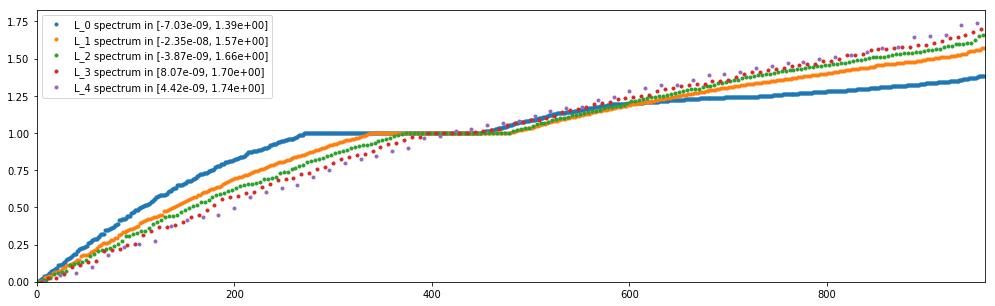

In [3]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(28, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
del A

# Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(FLAGS.dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32)
test_data = mnist.test.images.astype(np.float32)
train_labels = mnist.train.labels
val_labels = mnist.validation.labels
test_labels = mnist.test.labels

t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

W0708 20:27:52.894157 140030898751296 deprecation.py:323] From <ipython-input-4-87a1190cdfce>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0708 20:27:52.894679 140030898751296 deprecation.py:323] From /home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0708 20:27:52.895252 140030898751296 deprecation.py:323] From /home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz


W0708 20:27:53.118765 140030898751296 deprecation.py:323] From /home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Execution time: 1.74s


# Neural networks

In [5]:
#model = fc1()
#model = fc2(nhiddens=100)
#model = cnn2(K=5, F=10)  # K=28 is equivalent to filtering with fgcnn.
#model = fcnn2(F=10)
#model = fgcnn2(L[0], F=10)
#model = lgcnn2_2(L[0], F=10, K=10)
#model = cgcnn2_3(L[0], F=10, K=5)
#model = cgcnn2_4(L[0], F=10, K=5)
#model = cgcnn2_5(L[0], F=10, K=5)

if False:
    K = 5  # 5 or 5^2
    t_start = time.process_time()
    mnist.test._images = graph.lanczos(L, mnist.test._images.T, K).T
    mnist.train._images = graph.lanczos(L, mnist.train._images.T, K).T
    model = lgcnn2_1(L, F=10, K=K)
    print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
    ph_data = tf.placeholder(tf.float32, (FLAGS.batch_size, mnist.train.images.shape[1], K), 'data')

In [6]:
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 20
common['batch_size']     = 100
common['decay_steps']    = mnist.train.num_examples / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(mnist.train.labels) + 1  # number of classes

model_perf = utils.model_perf()

In [7]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 5e-4
    params['dropout']        = 1
    params['learning_rate']  = 0.02
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

W0708 20:28:07.899504 140030898751296 deprecation_wrapper.py:119] From ../lib/models.py:156: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 20:28:07.905232 140030898751296 deprecation_wrapper.py:119] From ../lib/models.py:972: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0708 20:28:07.906239 140030898751296 deprecation_wrapper.py:119] From ../lib/models.py:274: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0708 20:28:07.918074 140030898751296 deprecation_wrapper.py:119] From ../lib/models.py:277: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W0708 20:28:07.933116 140030898751296 deprecation.py:323] From ../lib/models.py:209: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0708 20:28:07.942888 140030898

NN architecture
  input: M_0 = 960
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 960 * 10 = 9600
    biases: M_1 = 10


W0708 20:28:08.100613 140030898751296 deprecation_wrapper.py:119] From ../lib/models.py:87: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.81e-01
  validation accuracy: 90.74 (4537 / 5000), f1 (weighted): 90.71, loss: 3.64e-01
  time: 1s (wall 1s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.60e-01
  validation accuracy: 91.76 (4588 / 5000), f1 (weighted): 91.71, loss: 3.35e-01
  time: 2s (wall 2s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 3.27e-01
  validation accuracy: 91.90 (4595 / 5000), f1 (weighted): 91.86, loss: 3.27e-01
  time: 3s (wall 2s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 3.28e-01
  validation accuracy: 92.20 (4610 / 5000), f1 (weighted): 92.17, loss: 3.20e-01
  time: 4s (wall 3s)
step 3000 / 11000 (epoch 5.45 / 20):
  learning_rate = 1.55e-02, loss_average = 3.28e-01
  validation accuracy: 92.12 (4606 / 5000), f1 (weighted): 92.08, loss: 3.17e-01
  time: 5s (wall 4s)


W0708 20:28:12.180305 140030898751296 deprecation.py:323] From /home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


step 3600 / 11000 (epoch 6.55 / 20):
  learning_rate = 1.47e-02, loss_average = 3.31e-01
  validation accuracy: 92.52 (4626 / 5000), f1 (weighted): 92.50, loss: 3.15e-01
  time: 6s (wall 4s)
step 4200 / 11000 (epoch 7.64 / 20):
  learning_rate = 1.40e-02, loss_average = 3.46e-01
  validation accuracy: 92.36 (4618 / 5000), f1 (weighted): 92.33, loss: 3.16e-01
  time: 6s (wall 5s)
step 4800 / 11000 (epoch 8.73 / 20):
  learning_rate = 1.33e-02, loss_average = 3.12e-01
  validation accuracy: 92.52 (4626 / 5000), f1 (weighted): 92.50, loss: 3.13e-01
  time: 7s (wall 6s)
step 5400 / 11000 (epoch 9.82 / 20):
  learning_rate = 1.26e-02, loss_average = 3.29e-01
  validation accuracy: 92.36 (4618 / 5000), f1 (weighted): 92.34, loss: 3.12e-01
  time: 8s (wall 6s)
step 6000 / 11000 (epoch 10.91 / 20):
  learning_rate = 1.20e-02, loss_average = 3.09e-01
  validation accuracy: 92.44 (4622 / 5000), f1 (weighted): 92.41, loss: 3.11e-01
  time: 9s (wall 7s)
step 6600 / 11000 (epoch 12.00 / 20):
  lear

W0708 20:28:20.088841 140030898751296 deprecation.py:323] From /home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


step 11000 / 11000 (epoch 20.00 / 20):
  learning_rate = 7.55e-03, loss_average = 3.10e-01
  validation accuracy: 92.72 (4636 / 5000), f1 (weighted): 92.71, loss: 3.09e-01
  time: 16s (wall 12s)
validation accuracy: peak = 92.72, mean = 92.53
train accuracy: 92.40 (50822 / 55000), f1 (weighted): 92.39, loss: 3.14e-01
time: 1s (wall 0s)
test  accuracy: 92.27 (9227 / 10000), f1 (weighted): 92.26, loss: 3.14e-01
time: 0s (wall 0s)


In [8]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['K']              = [20]
common['p']              = [1]
common['M']              = [C]

In [9]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 960
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 960 * 10 / 1 = 9600
    weights: F_0 * F_1 * K_1 = 1 * 10 * 960 = 9600
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9600 * 10 = 96000
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.96e-01
  validation accuracy: 87.98 (4399 / 5000), f1 (weighted): 87.88, loss: 3.95e-01
  time: 42s (wall 14s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.23e-01
  validation accuracy: 89.76 (4488 / 5000), f1 (weighted): 89.74, loss: 3.34e-01
  time: 82s (wall 26s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 3.50e-01
  validation accuracy: 91.42 (4571 / 5000), f1 (weighted): 91.40, loss: 2.98e-01
  time: 124s (wall 40s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 3.12e-01
  validation accuracy: 91.9

In [10]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 960
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 960 * 10 / 1 = 9600
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9600 * 10 = 96000
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.42e-01
  validation accuracy: 91.40 (4570 / 5000), f1 (weighted): 91.40, loss: 2.95e-01
  time: 42s (wall 14s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 2.95e-01
  validation accuracy: 92.88 (4644 / 5000), f1 (weighted): 92.87, loss: 2.53e-01
  time: 84s (wall 28s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 2.30e-01
  validation accuracy: 93.72 (4686 / 5000), f1 (weighted): 93.71, loss: 2.19e-01
  time: 125s (wall 41s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 2.13e-01
  validation accuracy: 94.22 

In [11]:
# With 'chebyshev2' and 'b2relu', it corresponds to cgcnn2_2(L[0], F=10, K=20).
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 960
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 960 * 10 / 1 = 9600
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9600 * 10 = 96000
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 1.69e-01
  validation accuracy: 96.28 (4814 / 5000), f1 (weighted): 96.28, loss: 1.34e-01
  time: 26s (wall 13s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 9.31e-02
  validation accuracy: 97.04 (4852 / 5000), f1 (weighted): 97.04, loss: 1.01e-01
  time: 53s (wall 26s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 1.06e-01
  validation accuracy: 97.34 (4867 / 5000), f1 (weighted): 97.34, loss: 8.54e-02
  time: 79s (wall 39s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 7.91e-02
  validation accuracy: 97.64 (

In [12]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['K']              = [25, 25]
common['p']              = [4, 4]
common['M']              = [512, C]

In [13]:
# Architecture of TF MNIST conv model (LeNet-5-like).
# Changes: regularization, dropout, decaying learning rate, momentum optimizer, stopping condition, size of biases.
# Differences: training data randomization, init conv1 biases at 0.
if True:
    name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0], L[2].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 960
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 960 * 32 / 4 = 7680
    weights: F_0 * F_1 * K_1 = 1 * 32 * 960 = 30720
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 240 * 64 / 4 = 3840
    weights: F_1 * F_2 * K_2 = 32 * 64 * 240 = 491520
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3840 * 512 = 1966080
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10


W0708 20:40:57.275303 140030898751296 deprecation_wrapper.py:119] From ../lib/models.py:928: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0708 20:40:57.324957 140030898751296 deprecation.py:506] From ../lib/models.py:969: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.89e+00
  validation accuracy: 87.90 (4395 / 5000), f1 (weighted): 87.84, loss: 3.81e+00
  time: 259s (wall 74s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.38e+00
  validation accuracy: 91.00 (4550 / 5000), f1 (weighted): 90.95, loss: 3.34e+00
  time: 519s (wall 147s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 3.02e+00
  validation accuracy: 93.60 (4680 / 5000), f1 (weighted): 93.59, loss: 2.97e+00
  time: 778s (wall 220s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 2.76e+00
  validation accuracy: 94.32 (4716 / 5000), f1 (weighted): 94.31, loss: 2.68e+00
  time: 1037s (wall 294s)
step 3000 / 11000 (epoch 5.45 / 20):
  learning_rate = 1.55e-02, loss_average = 2.50e+00
  validation accuracy: 94.94 (4747 / 5000), f1 (weighted): 94.94, loss: 2.44e+00
  time: 1296s (wall 367s)
step 3600 / 11000 (epoch 

In [14]:
if True:
    name = 'sgconv_sgconv_fc_softmax'  # 'Spline'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 960
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 960 * 32 / 4 = 7680
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 240 * 64 / 4 = 3840
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3840 * 512 = 1966080
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.76e+00
  validation accuracy: 92.08 (4604 / 5000), f1 (weighted): 92.07, loss: 3.67e+00
  time: 258s (wall 73s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.27e+00
  validation accuracy: 95.04 (4752 / 5000), f1 (weighted): 95.04, loss: 3.21e+00
  time: 516s (wall 146s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_

In [15]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 960
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 960 * 32 / 4 = 7680
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 240 * 64 / 4 = 3840
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3840 * 512 = 1966080
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.60e+00
  validation accuracy: 96.12 (4806 / 5000), f1 (weighted): 96.12, loss: 3.54e+00
  time: 528s (wall 186s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.19e+00
  validation accuracy: 97.44 (4872 / 5000), f1 (weighted): 97.44, loss: 3.13e+00
  time: 1057s (wall 372s)
step 1800 / 11000 (epoch 3.27 / 20):
  learnin

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
98.60 99.60   98.60 99.60   1.00e+00 9.72e-01   309   cgconv_cgconv_fc_softmax
98.27 99.41   98.27 99.41   5.67e-02 2.31e-02    21   cgconv_softmax
96.72 96.88   96.72 96.87   1.09e+00 1.08e+00   123   fgconv_fgconv_fc_softmax
95.18 94.85   95.18 94.84   1.67e-01 1.75e-01    22   fgconv_softmax
97.95 98.48   97.95 98.48   1.03e+00 1.02e+00   122   sgconv_sgconv_fc_softmax
96.77 97.11   96.77 97.11   1.12e-01 1.01e-01    22   sgconv_softmax
92.27 92.40   92.26 92.39   3.14e-01 3.14e-01     1   softmax


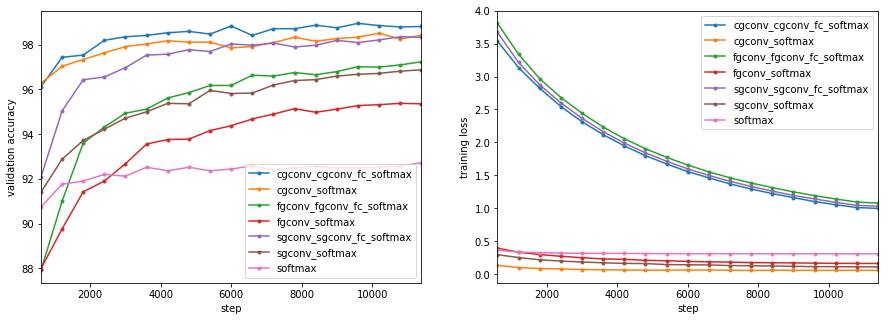

In [16]:
model_perf.show()

In [17]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))